In [3]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import sklearn
from matplotlib.gridspec import GridSpec

from udonpred_benchmarking.constants import DATA_DIR, PLOT_DIR
from udonpred_benchmarking.plots import FIGURE_KEYWORDS, METHODS, set_theme

/tmp/ipykernel_304574/234757892.py:72: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(PLOT_DIR / "barplot_per_residue.png")
/home/julius/projects/University/Publications/UdonPred/Benchmarking/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


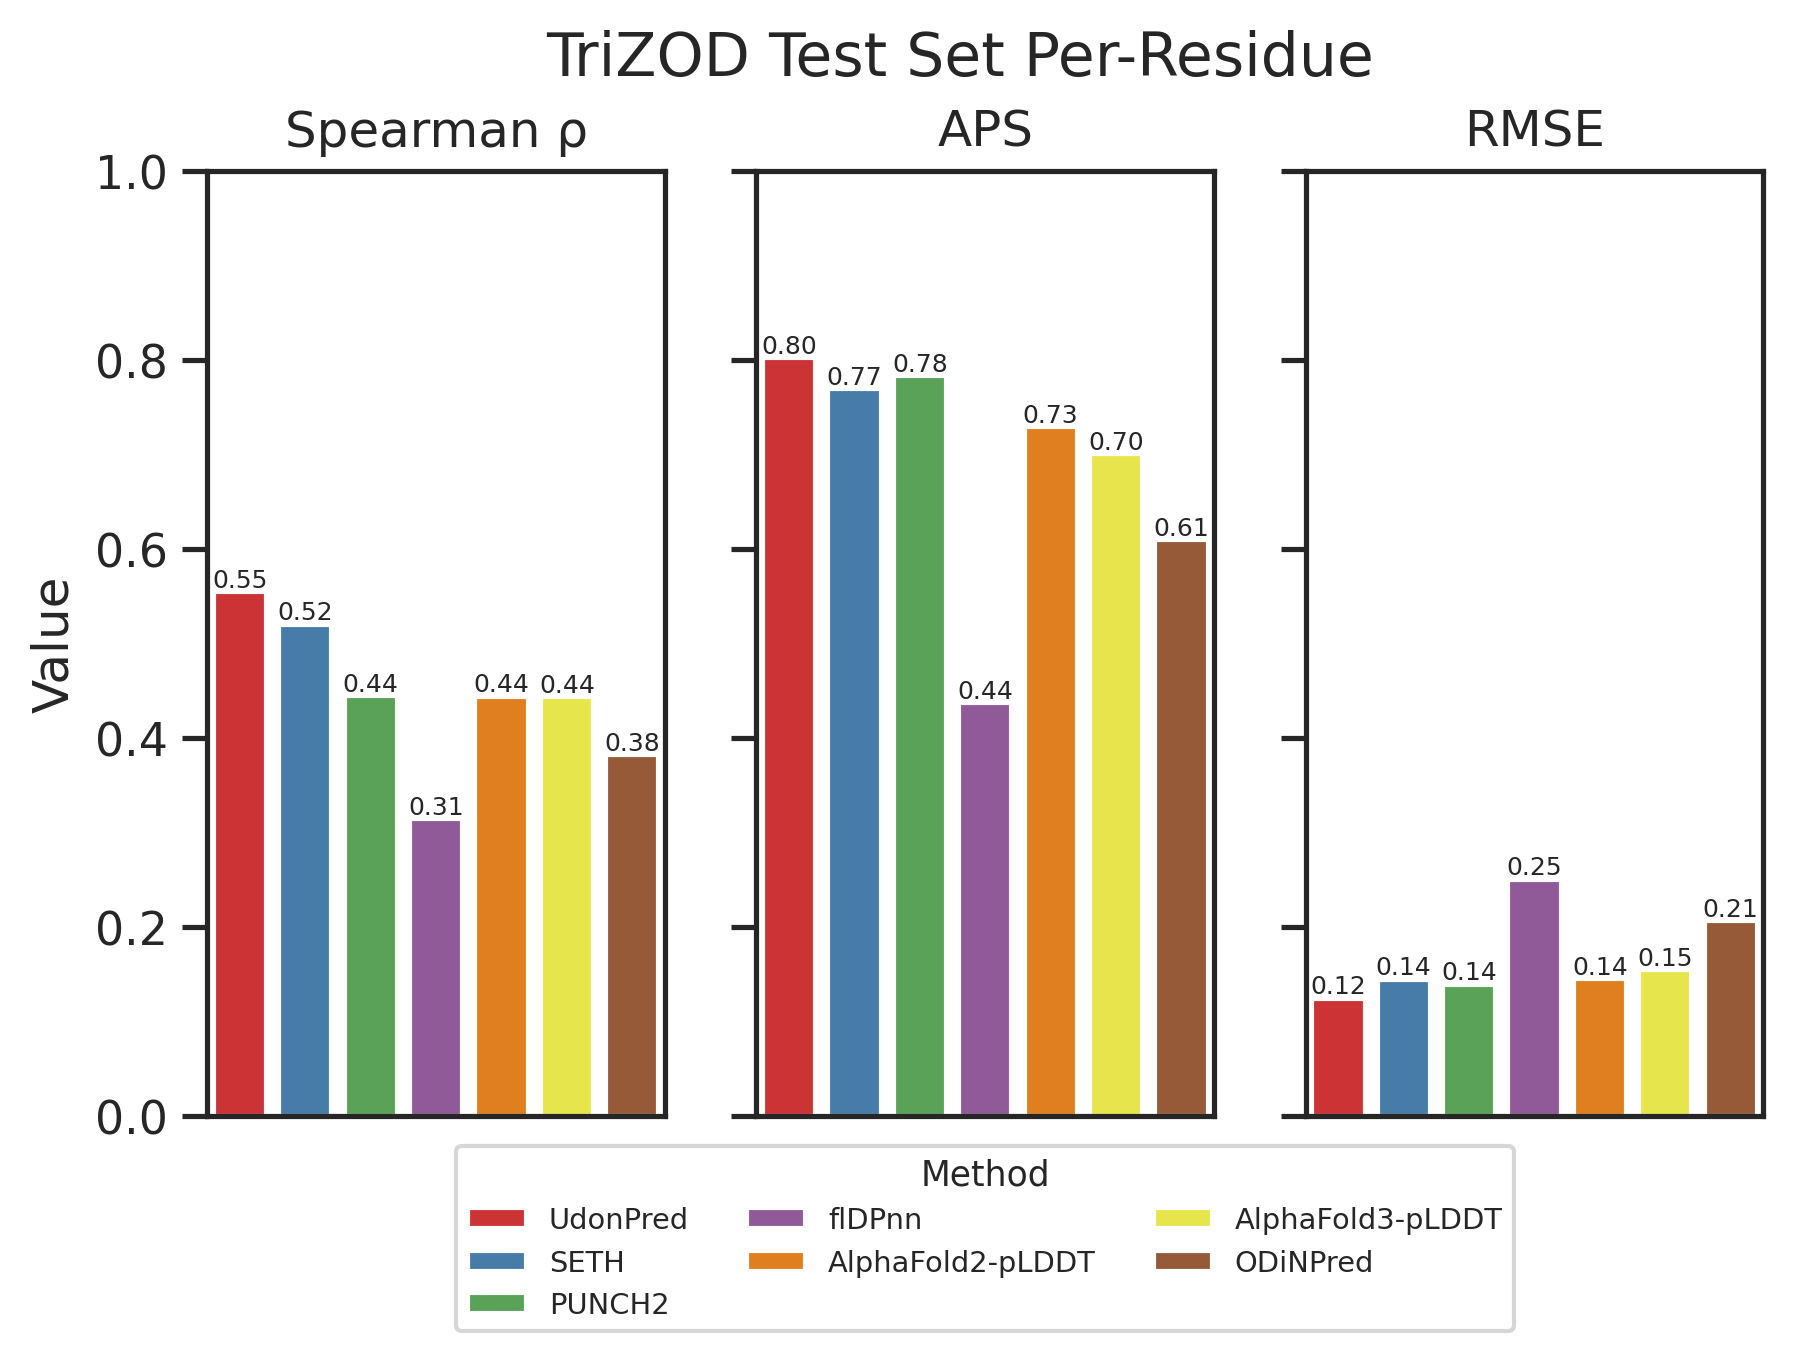

In [4]:
residue_df = pl.read_csv(DATA_DIR / "per_residue_predictions.csv")
set_theme()
gs = GridSpec(2, 3, height_ratios=[1, .05])

records = []
for method in METHODS:
    spearman = residue_df.select(pl.corr("pscores", f"{method}_continuous", method="spearman")).item(0, 0)
    auc = sklearn.metrics.roc_auc_score(residue_df["pscores_binary"], residue_df[f"{method}_continuous"])
    aps = sklearn.metrics.average_precision_score(residue_df["pscores_binary"], residue_df[f"{method}_continuous"])
    mse = sklearn.metrics.root_mean_squared_error(residue_df["pscores"], residue_df[f"{method}_continuous"])
    records.append({"method": method, "spearman": spearman, "auc": auc, "mse": mse, "aps": aps})

result_df = pl.from_records(records)

fig = plt.figure(**FIGURE_KEYWORDS)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
ax4 = fig.add_subplot(gs[1, :])
ax4.axis("off")

# Spearman
spearman_plot = sns.barplot(
    result_df,
    x="method",
    y="spearman",
    hue="method",
    ax=ax1,
    legend=True
)
spearman_plot.set_title("Spearman ρ")
spearman_plot.set_ylabel("Value")
spearman_plot.set_ylim([0, 1])
spearman_plot.get_legend().remove()

# APS
auc_plot = sns.barplot(
    result_df,
    x="method",
    y="aps",
    hue="method",
    ax=ax2,
)
auc_plot.set_title("APS")
auc_plot.set_ylabel(None)
plt.setp(auc_plot.get_yticklabels(), visible=False)

# MSE
mse_plot = sns.barplot(
    result_df,
    x="method",
    y="mse",
    hue="method",
    ax=ax3,
)
mse_plot.set_title("RMSE")
mse_plot.set_ylabel(None)
plt.setp(mse_plot.get_yticklabels(), visible=False)

# Bar labels
for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_visible(False)
    # bar labels
    for i in range(len(METHODS)):
        ax.bar_label(ax.containers[i], fontsize=6, fmt="%.2f")

# Legend
legend = ax4.legend(*ax1.get_legend_handles_labels(), loc="center", ncols=3, title="Method", fontsize="xx-small", title_fontsize="x-small")

plt.suptitle("TriZOD Test Set Per-Residue")

plt.savefig(PLOT_DIR / "barplot_per_residue.png")